### exp: eqtl prediction, sign prediction, dnabert2 for deep learning

In [35]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
model_size = ['small','middle','large']
# model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Esophagus_Mucosa'
data_path = '../../../../../datasets_embedding/dnabert2/eqtl_datasets/sign_prediction/' + tissue + '/'
# data_path = '../../../../../datasets_embedding/onehot/eqtl_datasets/sign_prediction/' + tissue + '/'
image_path = 'images_shuffled_seed17/'
# set seed
seed = 17
import random
random.seed(seed)
np.random.seed(seed)

#### model

In [37]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    print(train_data['dnabert_after'][i])
    feature_list += train_data['dnabert_before'][i].flatten().tolist()
    feature_list += train_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['dnabert_before'][i].flatten().tolist()
    feature_list += test_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0  ENSG00000187961.13   chr1_959193_G_A_b38         -1394  0.087591   
1   ENSG00000272512.1   chr1_989148_C_A_b38         -8903  0.452926   
2  ENSG00000178821.12  chr1_1925307_C_A_b38          6034  0.496231   
3   ENSG00000229393.1  chr1_2493455_T_C_b38         -1024  0.270073   
4  ENSG00000116213.15  chr1_3654319_C_T_b38          1558  0.492701   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0         69       72  1.511788e-20  0.456110  0.045976      1   
1        296      373  7.933526e-38  0.651714  0.044649      1   
2        319      408  1.560427e-29  0.608696  0.048948      1   
3        192      222  3.880312e-28  0.540057  0.044780      1   
4        307      405  8.474306e-53  0.511822  0.027893      1   

                                          seq_before  \
0  ACACCTGCAGGCACACAGGCATTCATGGATACACGTGCATACACAC...   
1  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
2  cgtgg

In [38]:
print(train_data['label'].unique())

[1 0]


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from TTT import TTTLinear, TTTCache  # Ensure these are correctly imported

class TTTBinaryClassifier(nn.Module):
    def __init__(self, num_heads, hidden_size, seq_length, num_classes=2, rope_theta=10000):
        super(TTTBinaryClassifier, self).__init__()
        self.ttt_linear = TTTLinear(num_heads=num_heads, hidden_size=hidden_size, mini_batch_size=64, rope_theta=rope_theta)
        self.classifier = nn.Linear(hidden_size * seq_length, num_classes)  # Classifier layer
        
    def forward(self, x):
        batch_size, seq_length, hidden_size = x.size()
        position_ids = torch.arange(seq_length).unsqueeze(0).repeat(batch_size, 1)
        cache = TTTCache(self.ttt_linear, batch_size, 64)
        x = self.ttt_linear(x, position_ids, cache)
        x = x.view(batch_size, -1)  # Flatten the output for the classifier
        output = self.classifier(x)
        return output

# Assuming X_train and Y_train are numpy arrays
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

# Model parameters
num_heads = 8
hidden_size = 512
seq_length = 3  # Adjust according to your data
num_classes = 2

# Create the model
model = TTTBinaryClassifier(num_heads=num_heads, hidden_size=hidden_size, seq_length=seq_length, num_classes=num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Reshape the data if necessary
X_train_tensor = X_train_tensor.view(-1, seq_length, hidden_size)  # Reshape to (batch_size, seq_length, hidden_size)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    
    for i in range(0, X_train_tensor.size(0), model.ttt_linear.mini_batch_size):
        # Get mini-batch inputs and targets
        inputs = X_train_tensor[i:i + model.ttt_linear.mini_batch_size]
        labels = Y_train_tensor[i:i + model.ttt_linear.mini_batch_size]
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete")


Epoch [1/50], Loss: 0.9706
Epoch [2/50], Loss: 0.6770
Epoch [3/50], Loss: 0.7124
Epoch [4/50], Loss: 0.7716
Epoch [5/50], Loss: 0.6597
Epoch [6/50], Loss: 0.7060
Epoch [7/50], Loss: 0.6748
Epoch [8/50], Loss: 0.6867
Epoch [9/50], Loss: 0.6802
Epoch [10/50], Loss: 0.6815
Epoch [11/50], Loss: 0.6816
Epoch [12/50], Loss: 0.6798
Epoch [13/50], Loss: 0.6813
Epoch [14/50], Loss: 0.6793
Epoch [15/50], Loss: 0.6804
Epoch [16/50], Loss: 0.6791
Epoch [17/50], Loss: 0.6792
Epoch [18/50], Loss: 0.6786
Epoch [19/50], Loss: 0.6781
Epoch [20/50], Loss: 0.6777
Epoch [21/50], Loss: 0.6771
Epoch [22/50], Loss: 0.6766
Epoch [23/50], Loss: 0.6760
Epoch [24/50], Loss: 0.6753
Epoch [25/50], Loss: 0.6747
Epoch [26/50], Loss: 0.6740
Epoch [27/50], Loss: 0.6732
Epoch [28/50], Loss: 0.6723
Epoch [29/50], Loss: 0.6713
Epoch [30/50], Loss: 0.6701
Epoch [31/50], Loss: 0.6686
Epoch [32/50], Loss: 0.6667
Epoch [33/50], Loss: 0.6644
Epoch [34/50], Loss: 0.6615
Epoch [35/50], Loss: 0.6578
Epoch [36/50], Loss: 0.6532
E

accuracy: 0.4807692307692308
precision: 0.5365853658536586
recall: 0.7333333333333333
f1-score: 0.6197183098591549


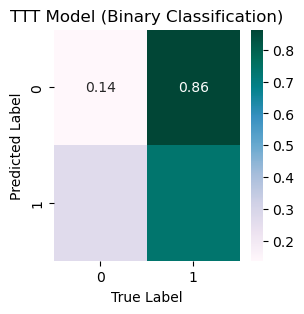

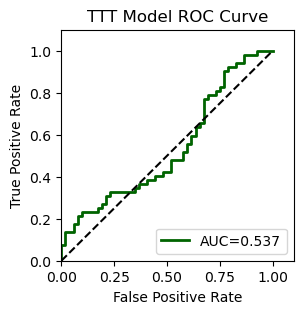

In [40]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc
import torch.nn.functional as F

# Assuming X_test and Y_test are already prepared and loaded as tensors
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, seq_length, hidden_size)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

    # Forward pass through the model
    outputs = model(X_test_tensor)
    y_score_pro = F.softmax(outputs, dim=1)  # Probabilities for each class
    y_score = torch.argmax(outputs, dim=1)   # Predicted class labels

# Convert tensors to numpy arrays for evaluation
y_score = y_score.numpy()
y_score_pro = y_score_pro.numpy()

# One-hot encoding for the true labels
y_one_hot = F.one_hot(Y_test_tensor, num_classes=2).numpy()

# Evaluation metrics
obj1 = confusion_matrix(Y_test, y_score)
print('accuracy: {}'.format(accuracy_score(Y_test, y_score)))
print('precision: {}'.format(precision_score(Y_test, y_score)))
print('recall: {}'.format(recall_score(Y_test, y_score)))
print('f1-score: {}'.format(f1_score(Y_test, y_score)))

# Update confusion matrix for visualization
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0]) / sum_all1, float(obj1[0][1]) / sum_all1],
        [float(obj1[1][0]) / sum_all2, float(obj1[1][1]) / sum_all2]
    ]
)

# Plot confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('TTT Model (Binary Classification)')
plt.savefig(image_path + 'cm-ttt.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(), y_score_pro.ravel())
auc_score = auc(fpr, tpr)

plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, linewidth=2, label='AUC=%.3f' % auc_score, color='#006400')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TTT Model ROC Curve')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-ttt.png', dpi=300, bbox_inches='tight')
plt.show()
